ΔΕΣΠΟΙΝΑ ΝΕΡΑΚΗ

https://github.com/DespoinaNeraki/Rock_Paper_Scissors/tree/main

# Import Libraries

In [76]:
import cv2
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dictionary for Rock-Paper-Scissors Game

In [78]:
dictionary = {"rock": 0, "scissors": 1, "paper": 2}

# Image Data Preprocessing for Rock-Paper-Scissors Classification

In [79]:
X = []
y = []
for ci, c in enumerate(['rock', 'scissors', 'paper']):
    for im_path in glob.glob(f"drive/MyDrive/archive/{c}/*.png"):
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = np.float32(cv2.resize(im, (120, 80), interpolation=cv2.INTER_AREA)) / 255.0
        X.append(im)
        y.append(ci)
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((2191, 80, 120, 3), (2191,))

# Train-Test Split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Image Augmentation Functions for Data Augmentation

In [81]:
def apply_vertical_flip(image, probability):
    if np.random.rand() < probability:
        image = cv2.flip(image, 0)
    return image

def apply_horizontal_flip(image, probability):
    if np.random.rand() < probability:
        image = cv2.flip(image, 1)
    return image

def apply_random_noise(image, mean=0, std_dev=0.05):
    noise = np.random.normal(mean, std_dev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def apply_random_transformations(image, vertical_flip_prob=0.5, horizontal_flip_prob=0.5, noise_prob=0.5):
    image = apply_vertical_flip(image, vertical_flip_prob)
    image = apply_horizontal_flip(image, horizontal_flip_prob)
    image = apply_random_noise(image)
    return image

# Applying Vertical Flips to Training Data

In [82]:
X_vertical = []
for image in X_train:
  image_vertical = apply_vertical_flip(image, 1)
  X_vertical.append(image_vertical)

X_vertical = np.array(X_vertical)
y_vertical = y_train.copy()

X_vertical.shape, y_vertical.shape

((1752, 80, 120, 3), (1752,))

# Applying Horizontal Flips to Training Data

In [83]:
X_horizontal = []
for image in X_train:
  image_horizontal = apply_horizontal_flip(image, 1)
  X_horizontal.append(image_horizontal)

X_horizontal = np.array(X_horizontal)
y_horizontal = y_train.copy()

X_horizontal.shape, y_horizontal.shape

((1752, 80, 120, 3), (1752,))

# Applying Vertical and Horizontal Flips to Training Data

In [84]:
X_vh = []
for image in X_train:
  image_vh = apply_vertical_flip(image, 1)
  image_vh = apply_horizontal_flip(image_vh, 1)
  X_vh.append(image_vh)

X_vh = np.array(X_vh)
y_vh = y_train.copy()

X_vh.shape, y_vh.shape

((1752, 80, 120, 3), (1752,))

# Combining Augmented Data for Training

In [85]:
X_train = np.concatenate((X_train, X_vertical, X_horizontal, X_vh),axis=0)

In [86]:
X_train.shape

(7008, 80, 120, 3)

In [87]:
y_train = np.concatenate((y_train, y_vertical, y_horizontal, y_vh), axis=0)

In [88]:
y_train.shape

(7008,)

# Applying Random Noise to Training Data

In [89]:
X_train_noise = []
for image in X_train:
  image_noise = apply_random_noise(image)
  X_train_noise.append(image)

X_train_noise = np.array(X_train_noise)

# Flattening Augmented Training Data

In [90]:
X_train_flatten = X_train_noise.reshape(X_train_noise.shape[0], -1)

# Dimensionality Reduction using PCA on Augmented Training Data

In [91]:
pca = PCA(n_components=0.9)
X_train_trans = pca.fit_transform(X_train_flatten)

In [92]:
X_train_trans.shape

(7008, 98)

# Flattening Testing Data

In [93]:
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [94]:
X_test_trans = pca.transform(X_test_flatten)

In [95]:
X_test_trans.shape

(439, 98)

# Grid Search for Random Forest Classifier Hyperparameters

Ο λόγος που χρησιμοποιούμε random forest είναι επειδή συνήθως τα ensemble μοντέλα αποδίδουν καλά και έχουν υψηλή αντοχή στο overfitting.

In [96]:
random_forest = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    {'n_estimators':[100, 250],
     'criterion': ['gini','entropy'],
     'min_samples_split': [2,3],
     'min_samples_leaf' : [1,2]
     },
    verbose=10
    )
random_forest.fit(X_train_trans, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/16] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   4.0s
[CV 2/5; 1/16] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/16] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   4.8s
[CV 3/5; 1/16] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/16] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.999 total time=   4.4s
[CV 4/5; 1/16] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/16] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   4.5s
[CV 5/5; 1/16] START criterion=gini, min_samples_leaf=1

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 250]},
             verbose=10)

In [97]:
random_forest.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [98]:
y_pred = random_forest.predict(X_train_trans)

In [99]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

1.0

In [100]:
y_pred = random_forest.predict(X_test_trans)

In [101]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.958997722095672

#  Grid Search for Support Vector Classifier (SVC) Hyperparameters

Ο λόγος που χρησιμοποιούμε svm είναι επειδή το dataset είναι μικρό και έχουμε μικρό αριθμό διαστάσεων μετά το pca.

In [102]:
svc = GridSearchCV(SVC(),{
    'kernel' : ['linear', 'rbf'],
    'C' : [0.1, 1, 10]
})

svc.fit(X_train_trans, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})

In [103]:
svc.best_params_

{'C': 10, 'kernel': 'rbf'}

In [104]:
y_pred = svc.predict(X_train_trans)

In [105]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

1.0

In [106]:
y_pred = svc.predict(X_test_trans)

In [107]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9840546697038725

# Rock-Paper-Scissors Game Simulation using a Trained Classifier

In [127]:
def rock_paper_scissors(player, image_set, labels, errors=[]):
  score=0
  w=0
  e=0
  s=0
  sc=[]
  for i in range(500):
    idx = np.random.randint(0, len(X_test))
    image = image_set[idx]
    image = apply_vertical_flip(image, 0.5)
    image = apply_horizontal_flip(image, 0.5)
    image = apply_random_noise(image, mean=0, std_dev=0.05)
    image = image.reshape(1, -1)
    image = pca.transform(image)
    y_pred = player.predict(image)
    y_true = labels[idx]
    hand = 0
    if y_pred==0:
      hand=2
    elif y_pred==1:
      hand=0
    else:
      hand=1

    reward=0
    if y_true==0:
      if hand==0:
        reward=0
      elif hand==1:
        reward=-1
      else:
        reward=1
    elif y_true==1:
      if hand==0:
        reward=1
      elif hand==1:
        reward=0
      else:
        reward=-1
    else:
      if hand==0:
        reward=-1
      elif hand==1:
        reward=1
      else:
        reward=0
    score=score+reward
    if reward==0:
      s=s+1
      errors.append((image_set[idx], y_pred))
    elif reward==1:
      w=w+1
    else:
      e=e+1
      errors.append((image_set[idx], y_pred))
    sc.append(score)
  print(f"score={score}, wins={w}, losses={e}, ties={s}")

  return sc

In [109]:
sc = rock_paper_scissors(svc, X_test, y_test)

score=482, wins=488, losses=6, ties=6


Text(0.5, 1.0, 'SVM Total Score per Round')

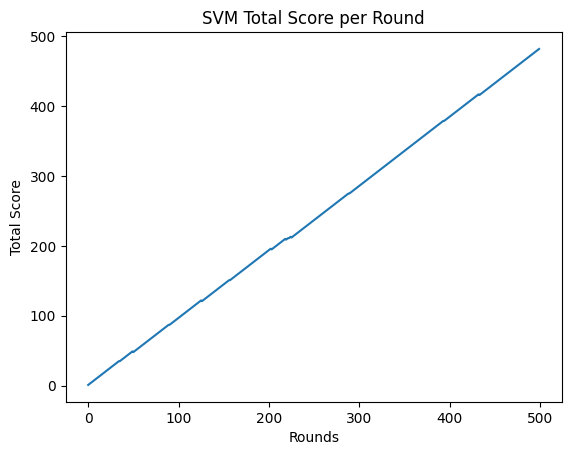

In [110]:
plt.plot(sc)
plt.xlabel("Rounds")
plt.ylabel("Total Score")
plt.title("SVM Total Score per Round")

In [111]:
sc = rock_paper_scissors(random_forest, X_test, y_test)

score=470, wins=480, losses=10, ties=10


Text(0.5, 1.0, ' Random Forest Total Score per Round')

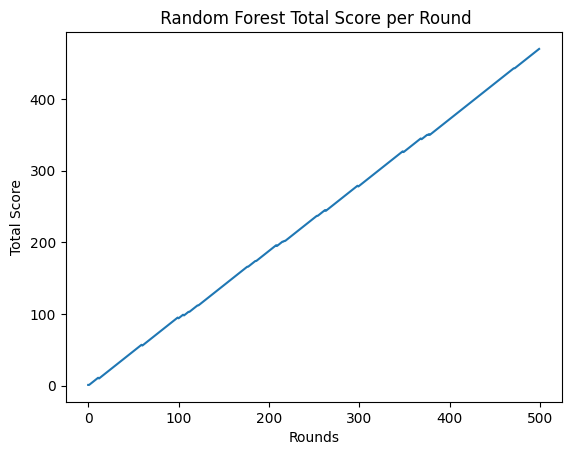

In [112]:
plt.plot(sc)
plt.xlabel("Rounds")
plt.ylabel("Total Score")
plt.title(" Random Forest Total Score per Round")

# Testing with a different dataset

In [113]:
X_new = []
y_new = []
for ci, c in enumerate(['rock', 'scissors', 'paper']):
    for im_path in glob.glob(f"drive/MyDrive/1/{c}/*.jpg"):
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = np.float32(cv2.resize(im, (120, 80), interpolation=cv2.INTER_AREA)) / 255.0
        X_new.append(im)
        y_new.append(ci)
X_new = np.array(X_new)
y_new = np.array(y_new)
X_new.shape, y_new.shape

((672, 80, 120, 3), (672,))

In [114]:
sc = rock_paper_scissors(svc, X_new, y_new)

score=98, wins=139, losses=41, ties=320


Text(0.5, 1.0, 'SVM Total Score per Round')

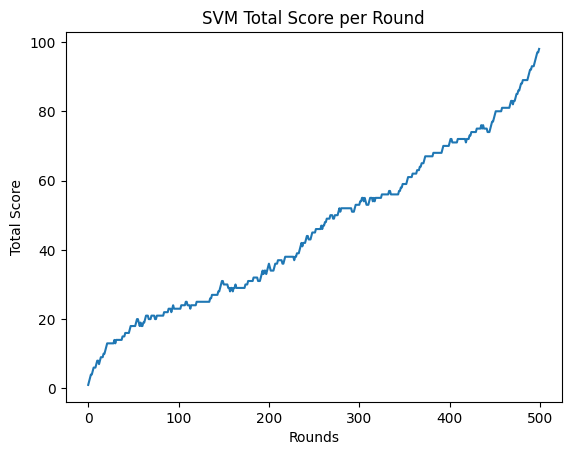

In [115]:
plt.plot(sc)
plt.xlabel("Rounds")
plt.ylabel("Total Score")
plt.title("SVM Total Score per Round")

In [116]:
sc = rock_paper_scissors(random_forest, X_new, y_new)

score=-324, wins=11, losses=335, ties=154


Text(0.5, 1.0, 'Random Forest Total Score per Round')

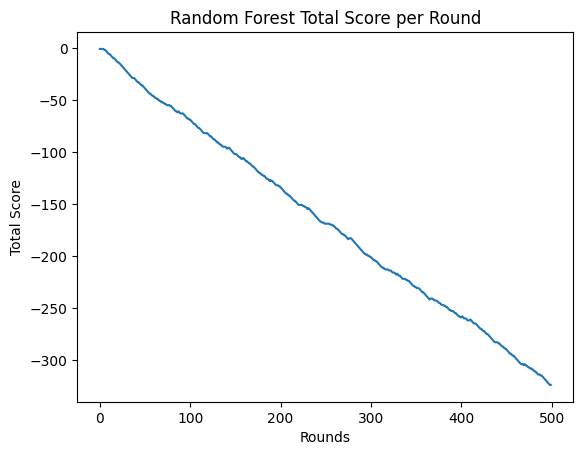

In [117]:
plt.plot(sc)
plt.xlabel("Rounds")
plt.ylabel("Total Score")
plt.title("Random Forest Total Score per Round")

# Errors in classification

In [128]:
error = []
rps = rock_paper_scissors(svc, X_test, y_test, error)

score=483, wins=489, losses=6, ties=5


array([2])

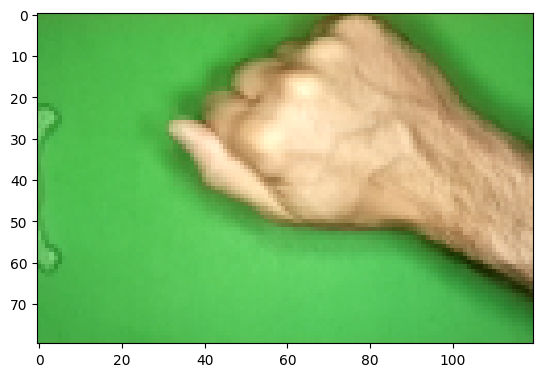

In [144]:
plt.imshow(error[0][0])
error[0][1]

Για την αποφυγή παρόμοιων σφαλμάτων κατηγοριοποίησης εφαρμόσαμε μείωση διαστάσεων με pca έτσι ώστε να κρατήσουμε
τα σημαντικότερα χαρακτηριστικά του dataset.

# Conclusion

Συμπεραίνεται ότι τα svm φαίνεται να αποδίδουν καλύτερα από τα random forest και στα δύο dataset. Είναι ενδιαφέρον να σημειωθεί ότι ακόμα και στο δεύτερο dataset, το svm καταφέρνει να κάνει σωστές προβλέψεις σε ικανοποιητικό βαθμό, παρόλο που είναι εκπαιδευμένο μόνο στο πρώτο. Από την άλλη πλευρά το random forest δεν καταφέρνει να κάνει σωστές προβλέψεις στο δεύτερο dataset.